# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from matplotlib import rcParams

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from keras.models import Sequential
from keras.layers import Dense

# Some preprocessing

In [2]:
data = pd.read_csv("./collected_data/prepared_data/pre_and_post_step_data.csv")
data_diff  = pd.read_csv("./collected_data/prepared_data/diff_step_data.csv")

In [4]:
rcParams["figure.figsize"] = 15, 13

array([[<AxesSubplot: title={'center': 'vertices_pre'}>,
        <AxesSubplot: title={'center': 'redexes_pre'}>,
        <AxesSubplot: title={'center': 'heights_pre'}>],
       [<AxesSubplot: title={'center': 'widths_pre'}>,
        <AxesSubplot: title={'center': 'vertices_post'}>,
        <AxesSubplot: title={'center': 'redexes_post'}>],
       [<AxesSubplot: title={'center': 'heights_post'}>,
        <AxesSubplot: title={'center': 'widths_post'}>,
        <AxesSubplot: title={'center': 'redex_depths'}>],
       [<AxesSubplot: title={'center': 'steps_time'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

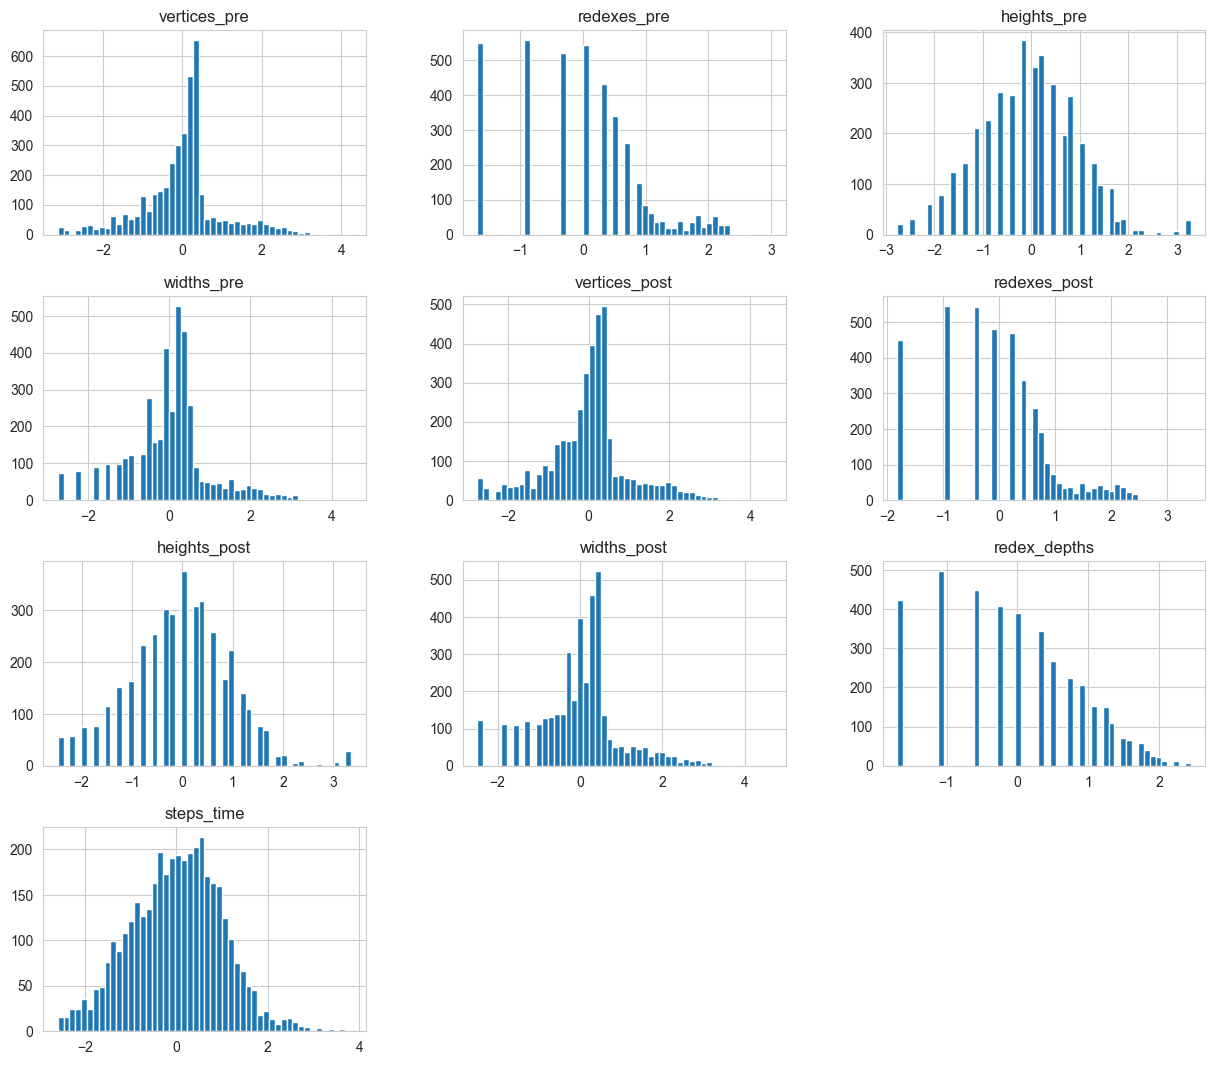

In [5]:
data_bc = pd.DataFrame()
power_trans = PowerTransformer(method='yeo-johnson')

for col_name in ['vertices_pre', 'redexes_pre', 'heights_pre', 'widths_pre',
                 'vertices_post', 'redexes_post', 'heights_post', 'widths_post',
                 'redex_depths', 'steps_time']:
    norm_col_data = power_trans.fit_transform(np.array(data[col_name]).reshape(-1, 1))
    data_bc[col_name] = list(norm_col_data.reshape(1, -1))[0]

data_bc.hist(bins=50)

In [6]:
data_for_training = data_bc.copy(deep=True)
data_for_training["heights_pre"] = data["heights_pre"]

In [8]:
data_diff_bc = pd.DataFrame()
power_trans = PowerTransformer(method='yeo-johnson')

for col_name in ['vertices_dif', 'redexes_dif', 'heights_dif', 'widths_dif']:
    norm_col_data = np.array(np.sqrt(np.abs(data_diff[col_name])))
    norm_col_data = power_trans.fit_transform(norm_col_data.reshape(-1, 1))
    data_for_training[col_name] = list(norm_col_data.reshape(1, -1)[0])

In [9]:
data_for_training.head()

,vertices_pre,redexes_pre,heights_pre,widths_pre,vertices_post,redexes_post,heights_post,widths_post,redex_depths,steps_time,vertices_dif,redexes_dif,heights_dif,widths_dif
0,0.303818,-0.328564,15,0.545405,0.335066,-0.386763,0.613884,0.563144,-0.259687,0.009806,-0.381652,0.375775,-1.025020,-0.329143
1,0.218395,-0.846167,15,0.478593,-0.395407,-0.895889,-0.773062,-0.208630,0.038549,0.372329,1.775024,0.375775,1.621566,2.053991
2,-0.690351,-1.675403,8,-0.437245,-1.784105,-1.816743,-1.925608,-1.547181,-1.696980,-1.253175,1.652516,0.375775,1.437038,1.869254
3,0.331197,0.533956,13,0.258094,0.359480,0.611282,0.425848,0.302521,0.517695,0.325372,-0.381652,-1.428979,0.582517,-0.329143
4,0.247439,0.533956,14,0.176681,0.284920,0.436091,0.040947,0.229286,1.211218,0.326341,-0.381652,0.375775,0.939005,-0.329143


In [10]:
def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2762
Examples for testing 1169


In [11]:
x_train, y_train = train_ds.drop('steps_time', axis=1), train_ds[["steps_time"]]
x_test, y_test = test_ds.drop('steps_time', axis=1), test_ds[["steps_time"]]

In [12]:
x_data, y_data = data_for_training.drop('steps_time', axis=1), data_for_training[["steps_time"]]

# Functions for drawing predicted values

In [13]:
rcParams['figure.figsize'] = 10, 12


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

# 1. Linear Regression

In [14]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

TRAIN Root Mean Squared Error(RMSE): 0.3022203231884396
TEST Root Mean Squared Error(RMSE): 0.3062843170452065


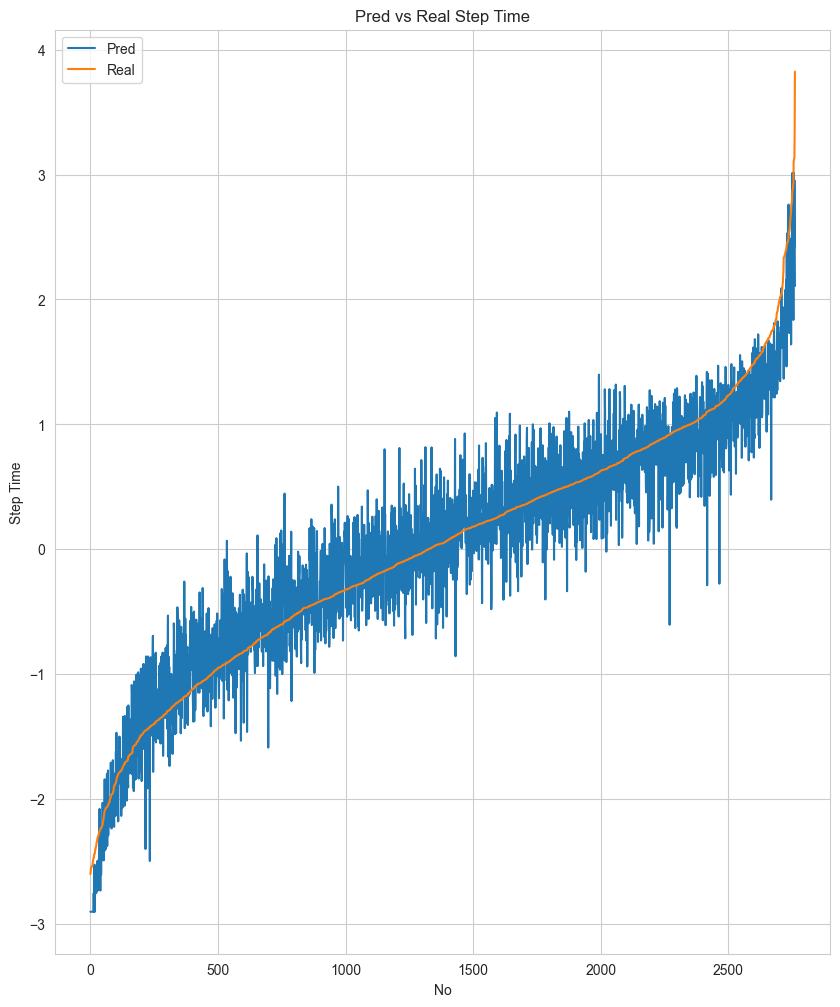

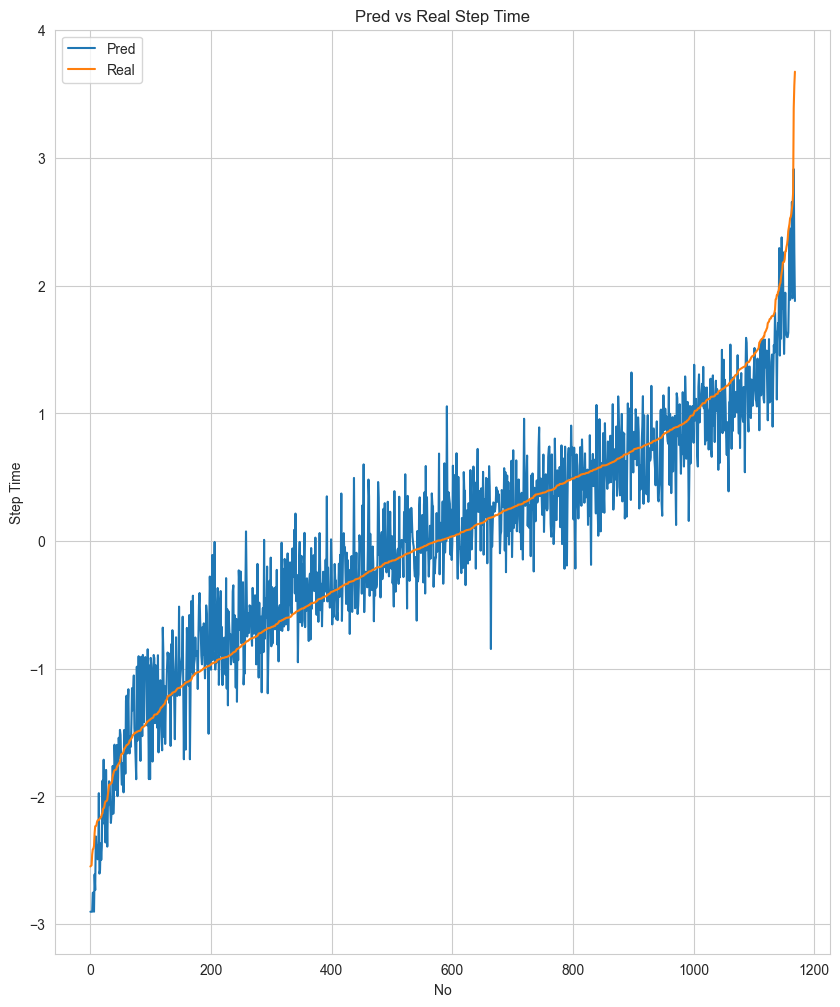

In [15]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [16]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)

ALL RMSE: 0.30322037618227804


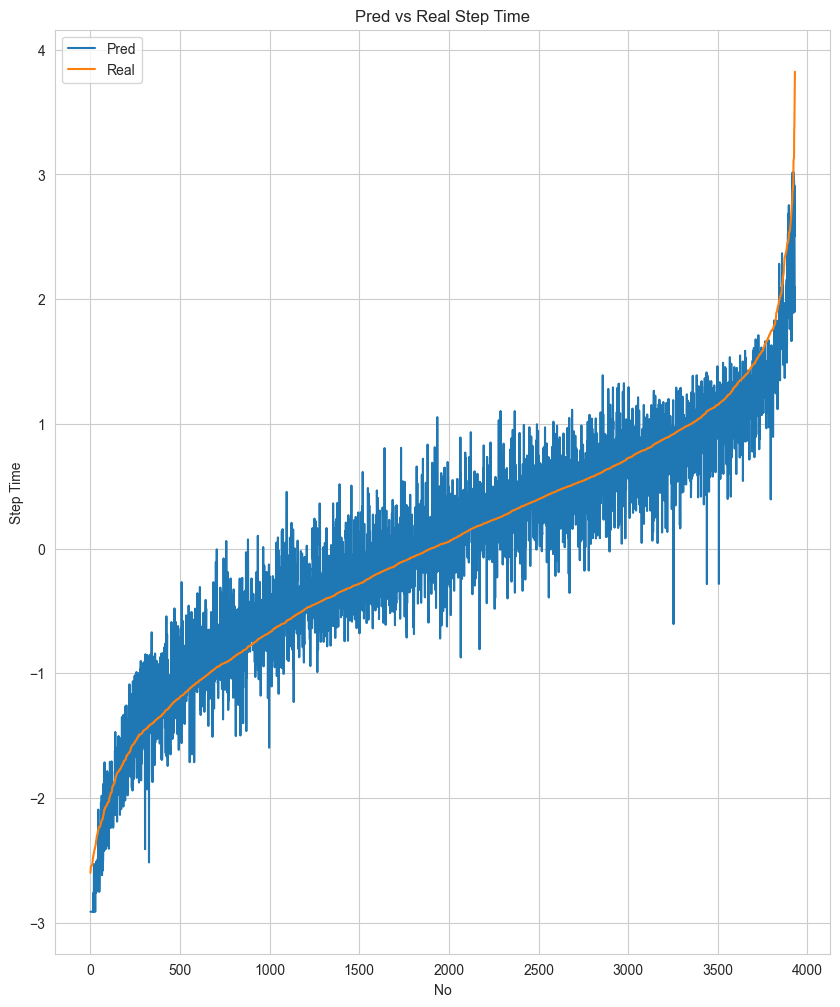

In [17]:
draw_pred_lines(list(y_data_pred[:, -1]), y_data["steps_time"].to_list())

# 2. ANN Regression

In [18]:
rcParams["figure.figsize"] = 7, 5

In [20]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=13))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=300)

Epoch 1/100
10/10 [==============================] - 0s 20ms/step - loss: 19.6742 - val_loss: 15.7559
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 15.6293 - val_loss: 12.8969
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 12.8668 - val_loss: 10.6047
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 10.5785 - val_loss: 8.6529
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 8.5960 - val_loss: 6.9113
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 6.8652 - val_loss: 5.4803
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 5.4160 - val_loss: 4.2472
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 4.1799 - val_loss: 3.2202
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 3.1633 - val_loss: 2.4151
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 2.3578 - val_loss: 1.7653
E

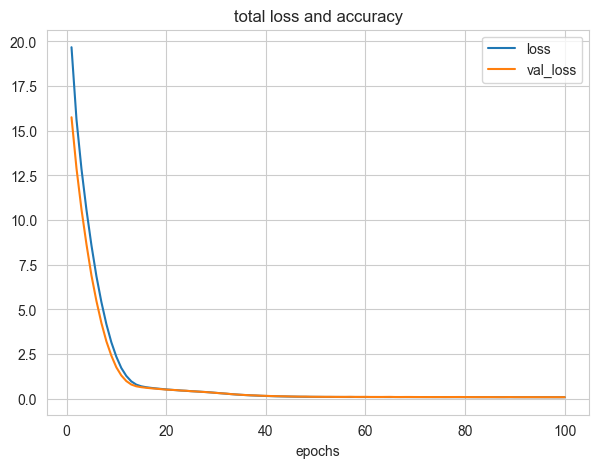

In [21]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [22]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)

123/123 [==============================] - 0s 809us/step
TRAIN Root Mean Squared Error(RMSE): 0.3059835819012109
TEST Root Mean Squared Error(RMSE): 0.3094370427655201
ALL RMSE: 0.3070146300953836


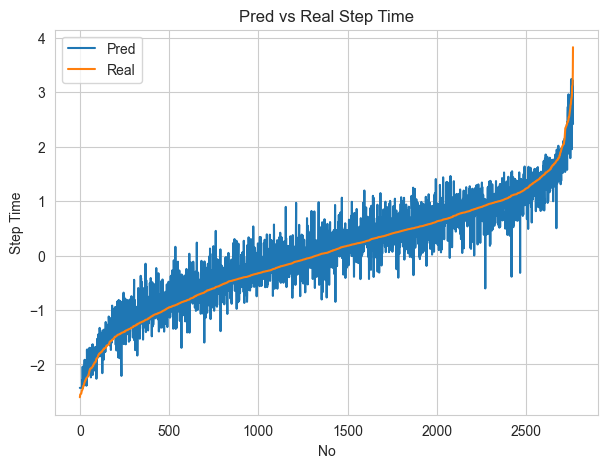

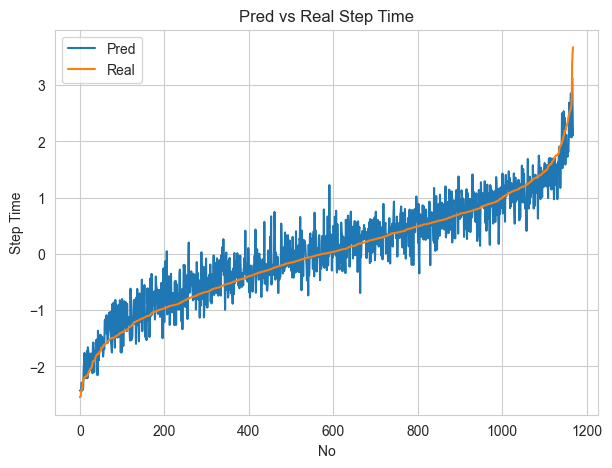

In [23]:
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [24]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=13))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2762/2762 [==============================] - 4s 1ms/step - loss: 0.2081 - val_loss: 0.0962
Epoch 2/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0983 - val_loss: 0.0837
Epoch 3/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0954 - val_loss: 0.0883
Epoch 4/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0913 - val_loss: 0.0869
Epoch 5/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0883 - val_loss: 0.0779
Epoch 6/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0861 - val_loss: 0.0927
Epoch 7/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0850 - val_loss: 0.0779
Epoch 8/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0844 - val_loss: 0.0772
Epoch 9/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0842 - val_loss: 0.0755
Epoch 10/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.082

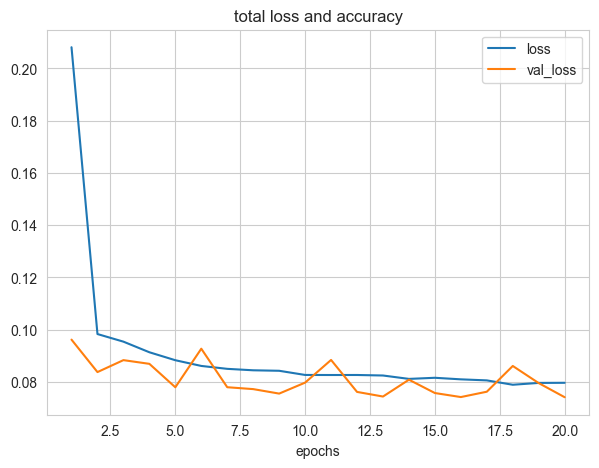

In [25]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 757us/step
TRAIN Root Mean Squared Error(RMSE): 0.26795405907109815
TEST Root Mean Squared Error(RMSE): 0.2721982970378729
ALL RMSE: 0.26922320078105727


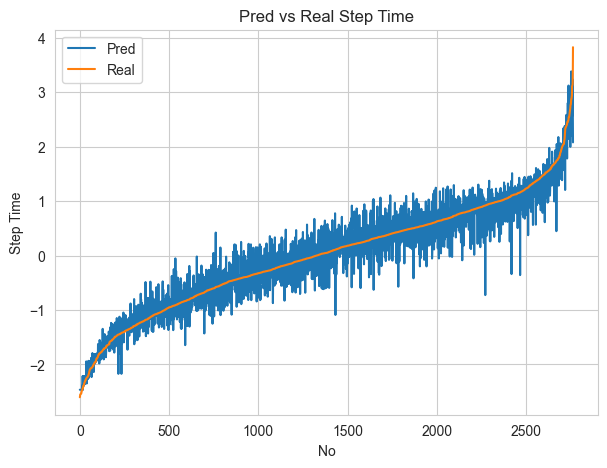

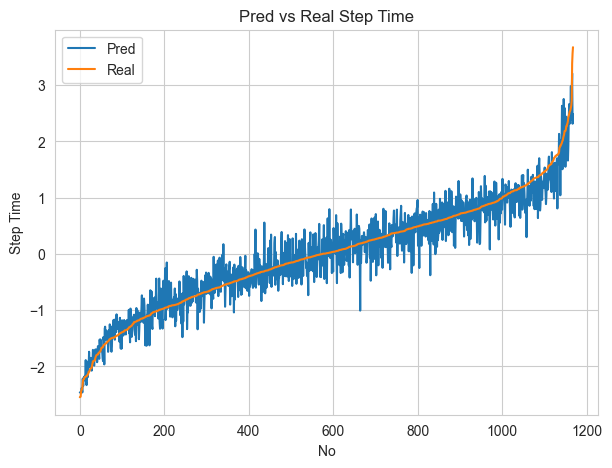

In [26]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())

In [27]:
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=13))
model.add(Dense(units=80, activation='relu'))
model.add(Dense(units=70, activation='relu' ))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1)

Epoch 1/20
2762/2762 [==============================] - 4s 1ms/step - loss: 0.1666 - val_loss: 0.1385
Epoch 2/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.1020 - val_loss: 0.1089
Epoch 3/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0949 - val_loss: 0.1058
Epoch 4/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0880 - val_loss: 0.0928
Epoch 5/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0851 - val_loss: 0.0932
Epoch 6/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0836 - val_loss: 0.0785
Epoch 7/20
2762/2762 [==============================] - 3s 1ms/step - loss: 0.0809 - val_loss: 0.0876
Epoch 8/20
2762/2762 [==============================] - 4s 1ms/step - loss: 0.0807 - val_loss: 0.0737
Epoch 9/20
2762/2762 [==============================] - 4s 1ms/step - loss: 0.0790 - val_loss: 0.0682
Epoch 10/20
2762/2762 [==============================] - 4s 1ms/step - loss: 0.078

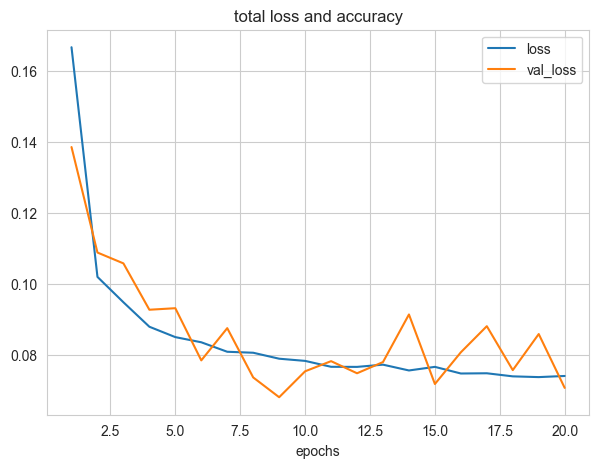

In [28]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label='val_loss')
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

123/123 [==============================] - 0s 1ms/step
TRAIN Root Mean Squared Error(RMSE): 0.2533767835137868
TEST Root Mean Squared Error(RMSE): 0.2660514686856539
ALL RMSE: 0.2572112380819613


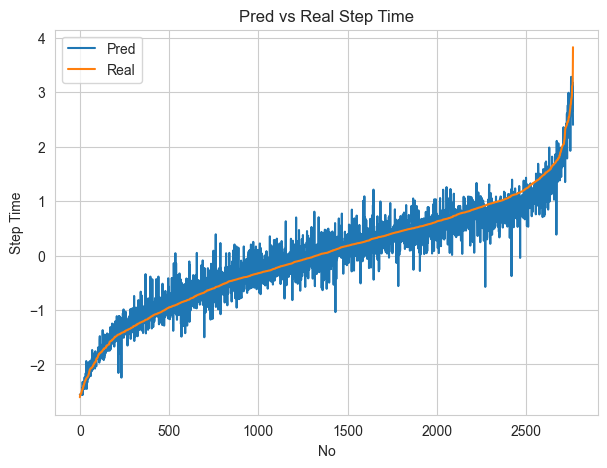

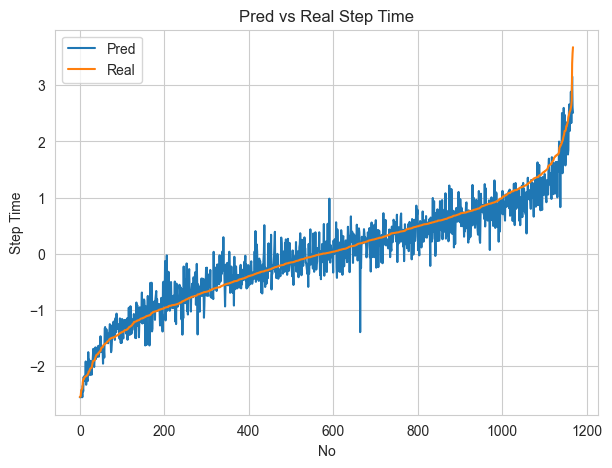

In [29]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["steps_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["steps_time"].to_list())